image size:  (1600, 900)


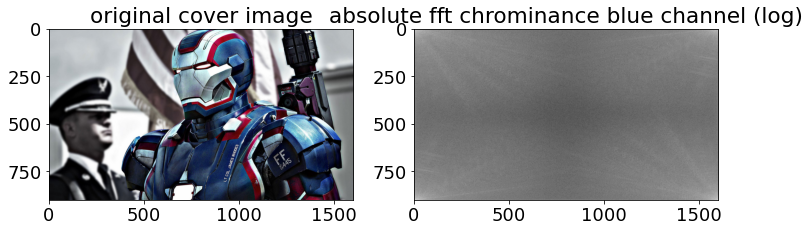

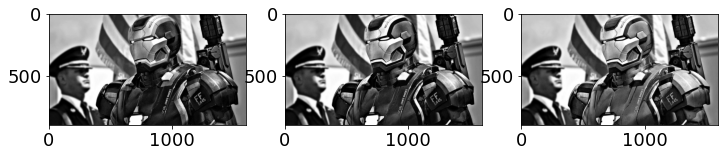

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size':18})

# specifying cover image path
# cover_img_path = "ImageSources\\tif\\lena_color_256.tif"
cover_img_path = "C:\\Users\\maxik\\Documents\\Semester_6\\Projektarbeit\\github_repo\\Steganography\\ImageSources\\jpg\\iron_patriot.jpg"
# cover_img_path = "C:\\Users\\maxik\\Documents\\Semester_6\\Projektarbeit\\github_repo\\Steganography\\ImageSources\\jfif\\obi-wan_kenobi.jfif"

# resize image if too large (>1600/900) and return Pillow Image object (not stored yet)
def resize(cover_img_path: str) -> Image:
    image = Image.open(cover_img_path)
    # get real size
    cols, rows = image.size

    # handle exception first
    if (cols < 1600) and (rows < 900):
        return image

    # calculate aspect ratio
    ratio = cols/rows

    # check if either dimension is greater than 1600:900
    if ratio >= 16/9:
        # resize columns to max (1600) and adjust rows accordingly
        if cols > 1600:
            new_cols = 1600
            new_rows = new_cols//ratio
    else:
        # resize rows to max (900) and adjust columns accordingly
        if rows > 900:
            new_rows = 900
            new_cols = new_rows//ratio

    im_resize = image.resize((round(new_cols), round(new_rows)))
    return im_resize

image = resize(cover_img_path)
# image = image.convert("YCbCr")

# Rot, Grün, Blau= image.split() #split image into its RGB channels
channel0, channel1, channel2 = image.split()

print("image size: ",image.size)

plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title("original cover image")

fft_abs = 10*np.log10(np.abs(np.fft.fft2(channel1)))
plt.subplot(122)
plt.imshow(fft_abs, cmap="gray")
plt.title("absolute fft chrominance blue channel (log)")
plt.figure()
plt.subplot(131)
plt.imshow(channel0, cmap="gray")
plt.subplot(132)
plt.imshow(channel1, cmap="gray")
plt.subplot(133)
plt.imshow(channel2, cmap="gray")

Functions for encoding and decoding

In [7]:
string="""Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋"""

""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text, gain):
    string_bits = text_to_bits(text)
    # convert each char to int
    message_bits = [int(i)*gain for i in string_bits]
    # get length of bitstream as bytes (overflow error if too large)
    formated = bin(len(message_bits))[2:]
    while len(formated) < 16:
        formated = '0' + formated
    message_len = [int(j)*gain for j in formated]
    # append length onto the first 2 bytes of the message
    message_bits = message_len + message_bits
    return message_bits


def text_from_bits_int(bits):
    # convert each element to string
    message_len_bits = bits[:16]
    message_len = ""
    for bit in message_len_bits:
        message_len = message_len + str(bit)
    message_len = int(message_len, 2)
    string_bits = [str(i) for i in bits[16:message_len+16]]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode, message_len

# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img


# convert inverse transformed message to parsable binary message
def message2bin(message, threshold):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital

Embed hidden message inside the absolute spektrum of the Fourier-Transform and reverse the process to save the resulting image as .png

MASK:

bin_encoded: [0, 0, 0, 0, 0, 100000, 0, 100000, 100000, 0, 0, 100000, 0, 0, 0, 0, 0, 100000, 0, 0]
cut:  0.3
message length: 1440
confirm: 64800.0


C:\Users\maxik\AppData\Local\Temp/ipykernel_39024/4293546484.py:36: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(10*np.log10(cover_fft_masked))


Text(0.5, 1.0, 'Red channel in frequency domain, filtered with mask (log)')

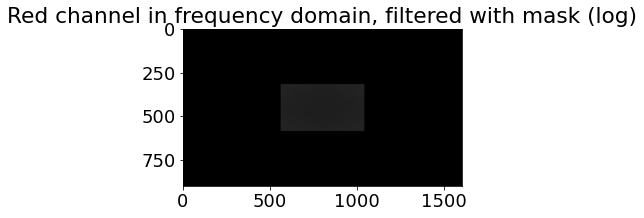

In [8]:
gain = 100000
max_cut = 0.3
bin_encoded =  text_to_bits_int(string, gain)
print("bin_encoded:", bin_encoded[:20])

def create_FFTmask(columns, rows, message, optcut = None):
    # calculate minimum part to be cut and add another 3% because of rounding errors and for "safety"
    cut = np.sqrt(2*len(message)/(rows*columns))*1.03
    if cut > max_cut:
        raise Exception("The message is too large. Major distortions are to be expected.")
    elif not optcut:
        cut = max_cut

    #cut off high frequencies from R channel
    mask = np.full((rows, columns), False)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    mask[row_start:row_stop, col_start:col_stop] = True  # rectangular

    # x-length of the mask
    x_len_mask = col_stop - col_start 
    # y-length of the mask
    y_len_mask = row_stop - row_start 

    print("cut: ", cut)
    print("message length:", len(message))
    print("confirm:", x_len_mask*y_len_mask/2)

    return mask, cut

cover_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded, False)

cover_fft_masked = np.abs(np.fft.fft2(channel1))*cover_fft_mask
im = Image.fromarray(10*np.log10(cover_fft_masked))
plt.figure(figsize=(5,5))
plt.imshow(im)
plt.title("Red channel in frequency domain, filtered with mask (log)")

C:\Users\maxik\AppData\Local\Temp/ipykernel_39024/2644007491.py:19: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(10*np.log10(fft_abs))


Abs FFT:  0.08588299999999549
loop:  0.0020686999999952604
inverse FFT:  0.26101030000000947


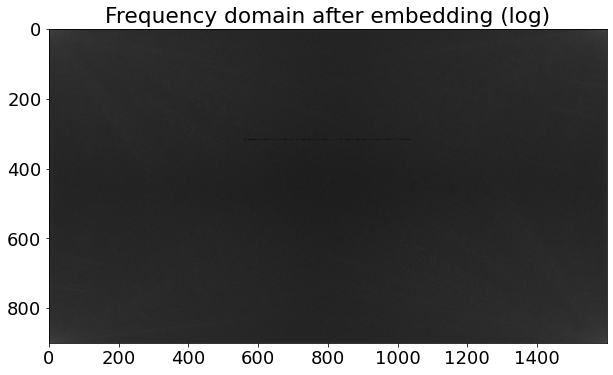

In [10]:
from time import perf_counter
# embed the message into the absolute fft and inverse the fourier transform to recover the channel
def embedBin2FFT(cover_channel, mask, message_digital):
    t0 = perf_counter()
    fft = np.fft.fft2(cover_channel)
    fft_abs = np.abs(fft)
    t1 = perf_counter()
    # cache message length
    message_len = len(message_digital)


    masked_fft = fft_abs[mask]
    for ii in range(message_len):
        masked_fft[ii] = message_digital[ii]
    fft_abs[mask] = masked_fft

    t2 = perf_counter()
    # plot absolute after embedding information
    im = Image.fromarray(10*np.log10(fft_abs))
    plt.figure(figsize=(10,10))
    plt.imshow(im)
    plt.title("Frequency domain after embedding (log)")

    #IFFT on single channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
    cover_masked = np.fft.ifft2(np.multiply(fft_abs, np.exp(np.multiply(1j, np.angle(fft))))).real
    t3 = perf_counter()
    print("Abs FFT: ", t1 - t0)
    print("loop: ", t2 - t1)
    print("inverse FFT: ", t3 - t2)
    return cover_masked

# get channel with embedded binary data
cover_masked = embedBin2FFT(channel1, cover_fft_mask, bin_encoded)

# normalize output
cover_masked_clip = np.clip(cover_masked, 0,255).astype("uint8")
# cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)

# merge layers
stego =  np.stack((channel0, cover_masked_clip, channel2), axis=2).astype('uint8')
# create steganogram
# stego_img = Image.fromarray(stego, "YCbCr").convert("RGB")
stego_img = Image.fromarray(stego)

Plot histograms

-5.406083890231061
260.70074495612266


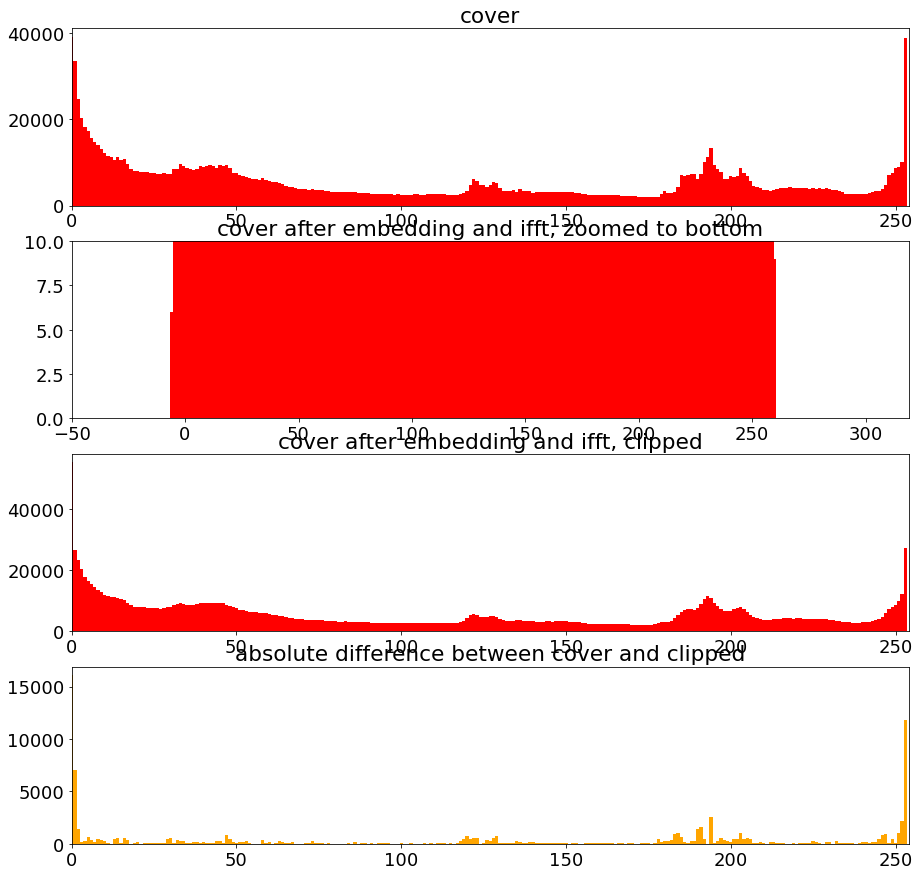

In [11]:
hist0, edges0 = np.histogram(np.array(channel1), bins=range(255))
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.bar(edges0[:-1], hist0, width = 1, color='red')
plt.xlim(min(edges0), max(edges0))
plt.title("cover")

hist1, edges1 = np.histogram(cover_masked, bins=range(-50,320))
plt.subplot(412)
plt.bar(edges1[:-1], hist1, width = 1, color='red')
plt.xlim(min(edges1), max(edges1))
plt.ylim(0,10)
plt.title("cover after embedding and ifft, zoomed to bottom")
print(np.min(cover_masked))
print(np.max(cover_masked))

hist2, edges2 = np.histogram(cover_masked_clip, bins=range(255))
plt.subplot(413)
plt.bar(edges2[:-1], hist2, width = 1, color='red')
plt.xlim(min(edges2), max(edges2))
plt.title("cover after embedding and ifft, clipped")

hist3 = np.abs(np.subtract(hist0,hist2))
plt.subplot(414)
plt.bar(edges2[:-1], hist3, width = 1, color='orange')
plt.xlim(min(edges2), max(edges2))
plt.title("absolute difference between cover and clipped")

plt.show()

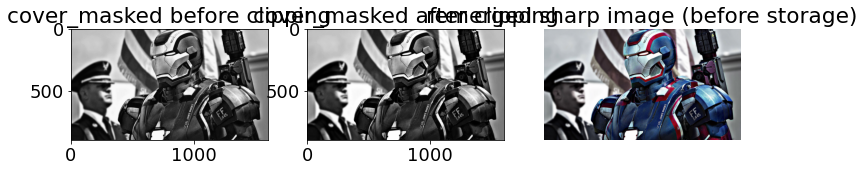

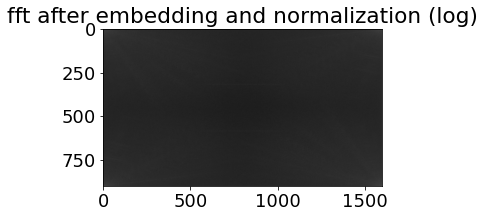

image saved


In [12]:
# some plots
plt.figure()
plt.subplot(131)
plt.imshow(cover_masked, cmap="gray")
plt.title("cover_masked before clipping")
plt.subplot(132)
plt.imshow(cover_masked_clip, cmap="gray")
plt.title("cover_masked after clipping")
plt.subplot(133)
plt.axis('off')
plt.imshow(stego_img) #Show picture with embeddes secret message
plt.title("remerged sharp image (before storage)")



sanity_check = Image.fromarray(10*np.log10(np.abs(np.fft.fft2(cover_masked_clip))))
plt.figure(figsize=(5,5))
plt.imshow(sanity_check, cmap="gray")
plt.title("fft after embedding and normalization (log)")

plt.show()

im = stego_img.save("ImageSources\\Steganograms\\remerged_sharp.png")     #save image as png
print("image saved")

Calculate mask from cut variable

max value stego_r:
 203


Text(0.5, 1.0, 'calculated fft mask')

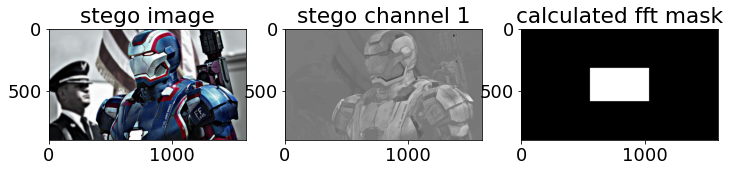

In [13]:
# load and plot image
stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp.png").convert("YCbCr")

plt.figure()
plt.subplot(131)
plt.imshow(stego_img)
plt.title("stego image")

steg_channel0, steg_channel1, steg_channel2 = stego_img.split() #split image into its RGB channels

plt.subplot(132)
plt.imshow(steg_channel1, cmap="gray")
plt.title("stego channel 1")

print("max value stego_r:\n", np.max(steg_channel1))

# calculate mask
def calculate_FFTmask(columns, rows, cut = None):
    if not cut:
        cut = max_cut
    stego_fft_mask = np.full((rows, columns), False)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    stego_fft_mask[row_start:row_stop, col_start:col_stop] = True  # rectangular

    return stego_fft_mask

# stego_fft_mask = calculate_FFTmask(*(stego_img.size), cut)
stego_fft_mask = calculate_FFTmask(*(stego_img.size))

plt.subplot(133)
plt.imshow(stego_fft_mask, cmap="gray")
plt.title("calculated fft mask")

predicted message length:  64800
[ 1790   549   830  1675   839 15264   527 15158 15356   635  1103 14998
  1343   948   116  1746  1131 16619  1040  1969]
threshold 9000.0
binary [0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0]
parsed message length 1424
bin_decoded:
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋


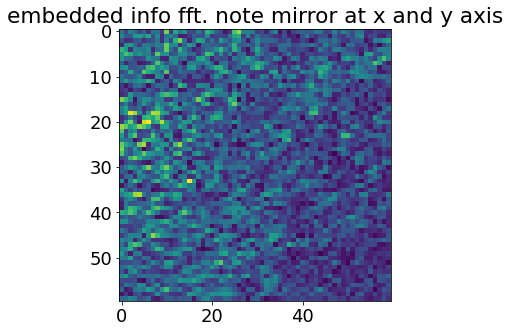

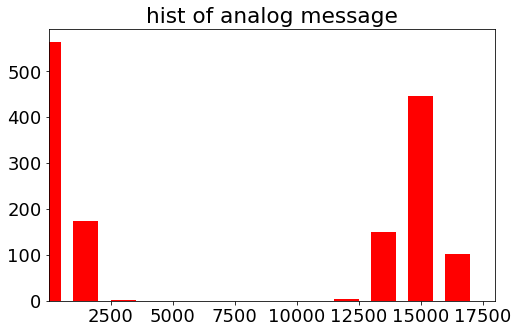

In [15]:
def get_message(stego_channel, mask):
    # transform R channel into frequency domain
    stego_fft =np.fft.fft2(stego_channel)
    stego_fft_abs = np.abs(stego_fft)

    plt.figure(figsize=(5,5))
    plt.imshow(stego_fft_abs[100:160, 100:160])
    plt.title("embedded info fft. note mirror at x and y axis")
    
    # calculate message length from mask -> predicted message length > true message length!
    message_length = int(np.count_nonzero(mask == True)//2)
    print("predicted message length: ", message_length)

    # create message buffer
    message=np.zeros(message_length, dtype='uint32')

    stego_fft_masked = stego_fft_abs[mask]
    for ii in range(message_length):
        message[ii] = stego_fft_masked[ii]
    
    # ylen, xlen = stego_fft_abs.shape
    # counter=0
    # for i in range(ylen):
    #     for j in range(xlen):
    #         if mask[i,j]==0:
    #             # loads also data not in the range of the hidden, but gets sliced off later
    #             if counter==message_length:
    #                 break
    #             message[counter] = stego_fft_abs[i,j]
    #             counter+=1 

    return message

message = get_message(steg_channel1, stego_fft_mask)

print(message[:20])

# calculate threshold
threshold = np.max(message)/2
print("threshold", threshold)

# convert message values to binary
binary = message2bin(message, threshold)
print("binary", binary[:20])  # first 2 bytes are length of the embedded message

# convert binary to utf-8
Text, length = text_from_bits_int(binary)
print("parsed message length", length)

# plot histogram
hist, edges = np.histogram(message[:length+16], bins="auto")
plt.figure(figsize=(8,5))
plt.bar(edges[:-1], hist, width = 1000, color='red')
plt.xlim(min(edges), max(edges))
plt.title("hist of analog message")

print("bin_decoded:")
print(Text)

#####################################################################################################################################################################################################################################
#####################################################################################################################################################################################################################################
#####################################################################################################################################################################################################################################

Now implement a gain finder algorithm

In [1]:
from FFT_stego import *

# cover_img_path ="ImageSources\\tif\\lena_color_256.tif"
cover_img_path ="ImageSources\\tif\\lena_color_512.tif"
# cover_img_path = "C:\\Users\\maxik\\Documents\\Semester_6\\Projektarbeit\\github_repo\\Steganography\\ImageSources\\jpg\\iron_patriot.jpg"

stego_img_path = stego_path_generator(cover_img_path, "png")
print(stego_img_path)
# input string
string=\
"""
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua.
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.\
"""

# set_maxcut(0.4)
# cut = steg_encode_simple(cover_img_path, string, colorspace="YCbCr")
%load_ext snakeviz
%snakeviz cut=steg_encode_simple(cover_img_path, string, True, recursive_cnt=4)
# cut = steg_encode_simple(cover_img_path, string, True, recursive_cnt=4)

Text = steg_decode(cut)
print("parsed text:", Text)
print("cut value:", cut)


c:\Users\maxik\Documents\Semester_6\Projektarbeit\github_repo\Steganography\ImageSources\Steganograms\lena_color_512_steg.png
gain:  10000 	text:  
At vero e
recur: 1 	gain:  5000 	parsed text:  
At vero e
recur: 2 	gain:  7500 	parsed text:  
At vero e
recur: 3 	gain:  6250 	parsed text:  
At vero e
recur: 4 	gain:  5625 	parsed text:  
At vero e
 
*** Profile stats marshalled to file 'C:\\Users\\maxik\\AppData\\Local\\Temp\\tmpm9_dqvye'. 
Embedding SnakeViz in this document...


parsed text: 
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua.
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.
cut value: 0.1684086173636722


Works with the following image file formats:
*   png
*   bmp
*   tiff
*   webp (not recommended)